# Call cellular infection status and viral tag assignment for infected cells
This Python Jupyter notebook uses the viral tags to determine which cells were infected, and the tag variant of the infecting virus for infected cells.

Import Python modules:

In [42]:
import anndata

import matplotlib.pyplot as plt

import numpy

import pandas as pd

import scanpy

Get `snakemake` variables [as described here](https://snakemake.readthedocs.io/en/stable/snakefiles/rules.html#jupyter-notebook-integration):

viral_tag_by_cell_csv = snakemake.input.viral_tag_by_cell_csv
matrix = snakemake.input.matrix
features = snakemake.input.features
cell_barcodes = snakemake.input.cell_barcodes
cell_annotations = snakemake.output.cell_annotations
plot = snakemake.output.plot
viral_genes = snakemake.params.viral_genes
viral_tags = snakemake.params.viral_tags
expt = snakemake.wildcards.expt

In [85]:
viral_tag_by_cell_csv = 'results/viral_fastq10x/scProgenyProduction_trial2_viral_tag_by_cell.csv.gz'
matrix = 'results/aligned_fastq10x/scProgenyProduction_trial2/Solo.out/GeneFull/filtered/matrix.mtx'
features = 'results/aligned_fastq10x/scProgenyProduction_trial2/Solo.out/GeneFull/filtered/features.tsv'
cell_barcodes = 'results/aligned_fastq10x/scProgenyProduction_trial2/Solo.out/GeneFull/filtered/barcodes.tsv'
cell_annotations = 'results/viral_tags_bcs_in_cells/scProgenyProduction_trial2_cell_barcodes_with_viral_tags.csv'
plot = 'results/viral_tags_bcs_in_cells/scProgenyProduction_trial2_assign_viral_tags_to_cells.svg'
viral_genes = ['fluPB2', 'fluPB1', 'fluPA', 'fluHA', 'fluNP', 'fluNA', 'fluM', 'fluNS']
viral_tags = ['wt', 'syn']
expt = 'scProgenyProduction_trial2'

This notebook assumes that there are exactly two viral tags, code does not work otherwise:

In [93]:
if len(viral_tags) != 2:
    raise ValueError('code assumes exactly two viral tags')

Read the cell-gene matrix into an [AnnData](https://anndata.readthedocs.io/) object:

In [36]:
adata = scanpy.read_mtx(matrix)
adata.var = pd.read_csv(cell_barcodes,
                        names=['cell_barcode'])
adata.obs = pd.read_csv(features,
                        sep='\t',
                        names=['ensemble_id', 'gene', 'feature_type'])

print(f"Read cell-gene matrix of {adata.n_vars} cells and {adata.n_obs} genes")

assert set(viral_genes).issubset(set(adata.obs['gene'])), 'cell-gene matrix missing viral genes'

Read cell-gene matrix of 7441 cells and 30959 genes


Now get for each cell:
 - total UMI corrected reads
 - UMI corrected viral and cellular
 - fraction of UMIs that are viral and cellular

In [130]:
umi_counts = (
    adata.var
    .assign(total_UMIs=numpy.sum(adata.X, axis=0).A1.astype(int),
            viral_UMIs=numpy.sum(adata[adata.obs['gene'].isin(viral_genes),].X,
                                 axis=0).A1.astype(int),
            cellular_UMIs=numpy.sum(adata[~adata.obs['gene'].isin(viral_genes),].X,
                                    axis=0).A1.astype(int),
            frac_viral_UMIs=lambda x: x['viral_UMIs'] / x['total_UMIs'],
            frac_cellular_UMIs=lambda x: x['cellular_UMIs'] / x['total_UMIs'],
            )
    )

umi_counts

,cell_barcode,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,frac_cellular_UMIs
0,AAACCCAAGTAGGTTA,5367,3166,2201,0.589901,0.410099
1,AAACCCACAAGGCCTC,10304,1485,8819,0.144119,0.855881
2,AAACCCACACACACGC,7395,3320,4075,0.448952,0.551048
3,AAACCCATCGTGCATA,2764,1597,1167,0.577786,0.422214
4,AAACCCATCTACTGCC,6313,3,6310,0.000475,0.999525
...,...,...,...,...,...,...
7436,TTTGGTTGTTAAGCAA,8528,29,8499,0.003401,0.996599
7437,TTTGGTTTCGTCGCTT,6492,6,6486,0.000924,0.999076
7438,TTTGTTGCATGTGGTT,3016,1680,1336,0.557029,0.442971
7439,TTTGTTGTCGTCGGGT,11070,2,11068,0.000181,0.999819


Now combine UMI counts with counts of viral tags, indentifying the "major" (more abundant) and "minor" (less abundant) viral tag for each cell, and also computing their ratio to total UMIs in each cell.

In [131]:
# read tag counts in tidy form
tidy_tag_counts = pd.read_csv(viral_tag_by_cell_csv)

# check tag count values
assert set(tidy_tag_counts['tag_variant']).issubset(set(viral_tags)), 'unrecognized viral tag'
assert set(tidy_tag_counts['cell_barcode']).issubset(set(umi_counts['cell_barcode'])), 'unrecognized cell barcode'
assert set(tidy_tag_counts['gene']).issubset(set(viral_genes)), 'unrecognized viral gene'

# for each cell barcode, identify more abundant (major) and less abundant (minor) tag and get counts
tag_counts = (
    tidy_tag_counts
    # sum counts across viral genes
    .groupby(['cell_barcode', 'tag_variant'], as_index=False)
    .aggregate(count=pd.NamedAgg('count', 'sum'))
    # fill counts of 0 for cells missing any counts for a tag
    .merge(pd.concat([pd.DataFrame({'cell_barcode': umi_counts['cell_barcode'],
                         'tag_variant': viral_tag})
                      for viral_tag in viral_tags]),
           how='right', on=['cell_barcode', 'tag_variant'])
    .assign(count=lambda x: x['count'].fillna(0).astype(int))
    # get major and minor viral tag and their counts
    .sort_values('count', ascending=False)
    .groupby('cell_barcode', as_index=False)
    .aggregate(viral_tag_counts_total=pd.NamedAgg('count', 'sum'),
               viral_tag_major=pd.NamedAgg('tag_variant', 'first'),
               viral_tag_counts_major=pd.NamedAgg('count', 'max'),
               viral_tag_minor=pd.NamedAgg('tag_variant', 'last'),
               viral_tag_counts_minor=pd.NamedAgg('count', 'min')
               )
    # add the UMI counts
    .merge(umi_counts, on='cell_barcode', how='outer')
    # compute ratio of viral tag to total UMIs
    .assign(viral_tag_major_to_total_UMI=lambda x: x['viral_tag_counts_major'] / x['total_UMIs'],
            viral_tag_minor_to_total_UMI=lambda x: x['viral_tag_counts_minor'] / x['total_UMIs'])
    )

assert tag_counts.notnull().all().all()

tag_counts

,cell_barcode,viral_tag_counts_total,viral_tag_major,viral_tag_counts_major,viral_tag_minor,viral_tag_counts_minor,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,frac_cellular_UMIs,viral_tag_major_to_total_UMI,viral_tag_minor_to_total_UMI
0,AAACCCAAGTAGGTTA,2512,syn,2480,wt,32,5367,3166,2201,0.589901,0.410099,0.462083,0.005962
1,AAACCCACAAGGCCTC,1154,syn,1101,wt,53,10304,1485,8819,0.144119,0.855881,0.106852,0.005144
2,AAACCCACACACACGC,2378,syn,1774,wt,604,7395,3320,4075,0.448952,0.551048,0.239892,0.081677
3,AAACCCATCGTGCATA,1157,syn,1140,wt,17,2764,1597,1167,0.577786,0.422214,0.412446,0.006151
4,AAACCCATCTACTGCC,2,wt,1,syn,1,6313,3,6310,0.000475,0.999525,0.000158,0.000158
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,TTTGGTTGTTAAGCAA,17,wt,14,syn,3,8528,29,8499,0.003401,0.996599,0.001642,0.000352
7437,TTTGGTTTCGTCGCTT,5,wt,3,syn,2,6492,6,6486,0.000924,0.999076,0.000462,0.000308
7438,TTTGTTGCATGTGGTT,1180,wt,1168,syn,12,3016,1680,1336,0.557029,0.442971,0.387268,0.003979
7439,TTTGTTGTCGTCGGGT,2,syn,1,wt,1,11070,2,11068,0.000181,0.999819,0.000090,0.000090


Make some plots:

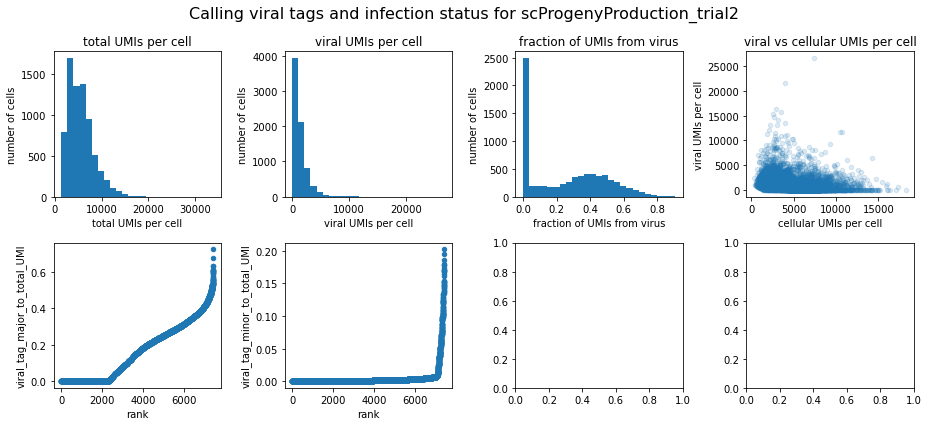

In [168]:
fig, axes = plt.subplots(ncols=4,
                         nrows=2,
                         figsize=(13, 6)
                         )

# distribution of total and viral UMIs per cell
for umi_type, ax in zip(['total', 'viral'], axes.ravel()):
    _ = tag_counts.plot(y=f"{umi_type}_UMIs",
                        kind='hist',
                        bins=25,
                        ax=ax,
                        legend=False,
                        )
    _ = ax.set_xlabel(f"{umi_type} UMIs per cell")
    _ = ax.set_ylabel('number of cells')
    _ = ax.set_title(f"{umi_type} UMIs per cell")
    
# fraction of UMIs that are viral
ax = tag_counts.plot(y='frac_viral_UMIs',
                     kind='hist',
                     bins=25,
                     ax=axes.ravel()[2],
                     legend=False)
_ = ax.set_xlabel('fraction of UMIs from virus')
_ = ax.set_ylabel('number of cells')
_ = ax.set_title('fraction of UMIs from virus')

# correlation of viral and cellular UMIs
ax = tag_counts.plot(x='cellular_UMIs',
                     y='viral_UMIs',
                     kind='scatter',
                     ax=axes.ravel()[3],
                     alpha=0.15,
                     legend=False)
_ = ax.set_xlabel('cellular UMIs per cell')
_ = ax.set_ylabel('viral UMIs per cell')
_ = ax.set_title('viral vs cellular UMIs per cell')

# plot viral tag to total UMI ratios
for tag_type, ax in zip(['major', 'minor'], axes.ravel()[4: ]):
    ax = (tag_counts
          .sort_values(f"viral_tag_{tag_type}_to_total_UMI")
          .reset_index(drop=True)
          .assign(rank=lambda x: x.index + 1)
          ).plot(x='rank',
                 y=f"viral_tag_{tag_type}_to_total_UMI",
                 kind='scatter',
                 ax=ax)
    
# save figure
fig.suptitle(f"Calling viral tags and infection status for {expt}", size=16)
fig.tight_layout()